In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from explicit_functions import dual_control, upstream_repression, no_control, downstream_activation, loss_biological

In [203]:
da = pd.read_csv('da_background.csv')
da['circuit'] = 'Downstream Activation'
ur = pd.read_csv('ur_background.csv')
ur['circuit'] = 'Upstream Repression'
nc = pd.read_csv('nc_background.csv')
nc['circuit'] = 'No Control'
dc = pd.read_csv('dc_background.csv')
dc['circuit'] = 'Dual Control'


perturbed_dc = pd.read_csv('dc_perturbation_grid.csv')
perturbed_dc['circuit'] = 'Dual Control'
perturbed_da = pd.read_csv('da_perturbation_grid.csv')
perturbed_da['circuit'] = 'Downstream Activation'
perturbed_nc = pd.read_csv('nc_perturbation_grid.csv')
perturbed_nc['circuit'] = 'No Control'
perturbed_ur = pd.read_csv('ur_perturbation_grid.csv')
perturbed_ur['circuit'] = 'Upstream Repression'

perturbed_dc1 = pd.read_csv('dc_perturbation_grid_1s.csv')
perturbed_dc1['circuit'] = 'Dual Control'
perturbed_da1 = pd.read_csv('da_perturbation_grid_1s.csv')
perturbed_da1['circuit'] = 'Downstream Activation'
perturbed_nc1 = pd.read_csv('nc_perturbation_grid_1s.csv')
perturbed_nc1['circuit'] = 'No Control'
perturbed_ur1 = pd.read_csv('ur_perturbation_grid_1s.csv')
perturbed_ur1['circuit'] = 'Upstream Repression'

perturbed = pd.concat([perturbed_dc, perturbed_da, perturbed_nc, perturbed_ur, perturbed_dc1, perturbed_da1, perturbed_nc1, perturbed_ur1])
perturbed['perturbed'] = True
background = pd.concat([da, ur, nc, dc])
background['perturbed'] = False
combined = pd.concat([perturbed, background])
combined = combined.loc[combined.num_iters > 150]
combined['km_perturb'] = combined.km_perturb.fillna(1)
combined['kc_perturb'] = combined.kc_perturb.fillna(1)

combined.to_csv('perturb_viz_data_with_background.csv')

In [204]:

features = ['k1', 'k2', 'theta1', 'theta2', 'loss']

x = combined.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1372 samples in 0.002s...
[t-SNE] Computed neighbors for 1372 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1372
[t-SNE] Computed conditional probabilities for sample 1372 / 1372
[t-SNE] Mean sigma: 0.529868
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.991848
[t-SNE] KL divergence after 300 iterations: 0.791856


In [205]:
perturbed = combined.loc[combined.perturbed == True].sort_values(by='circuit').reset_index(drop=True)
background = combined.loc[combined.perturbed == False].sort_values(by='circuit').reset_index(drop=True)

#Normalize scaled perturbations
perturbed['normalized_km_perturb'] = [1-(perturbed.km_perturb[i] - perturbed.km_perturb.min())/(perturbed.km_perturb.max() - perturbed.km_perturb.min()) for i in range(len(perturbed))] 
perturbed['normalized_kc_perturb'] = [1-(perturbed.kc_perturb[i] - perturbed.kc_perturb.min())/(perturbed.kc_perturb.max() - perturbed.kc_perturb.min()) for i in range(len(perturbed))] 
perturbed['sum_perturb'] = [(perturbed.normalized_km_perturb[i] + perturbed.normalized_kc_perturb[i])  for i in range(len(perturbed))] 
perturbed['normalized_perturbs'] = [ (perturbed.sum_perturb[i] - perturbed.sum_perturb.min())/(perturbed.sum_perturb.max() - perturbed.sum_perturb.min())  for i in range(len(perturbed))] 


Text(0, 0.5, 'Principal Component 2')

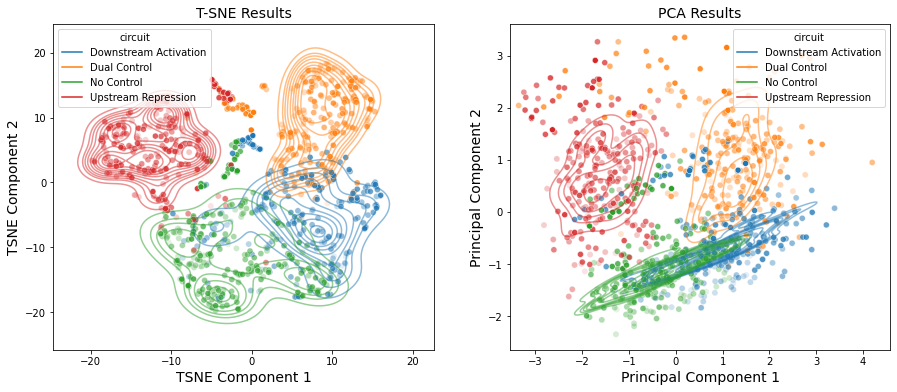

In [189]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
alphas = perturbed.normalized_perturbs.sort_values().unique()
for alpha in alphas[1:]:
    sns.scatterplot(x="tsne1", y="tsne2",
                    data=perturbed[perturbed.normalized_perturbs == alpha], hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
alphas = perturbed.normalized_perturbs.sort_values().unique()
for alpha in alphas[1:]:
    sns.scatterplot(x="pc1", y="pc2",
                    data=perturbed[perturbed.normalized_perturbs == alpha], hue='circuit', alpha=alpha, ax=ax)

sns.kdeplot(
    data=background,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

Text(0, 0.5, 'TSNE Component 2')

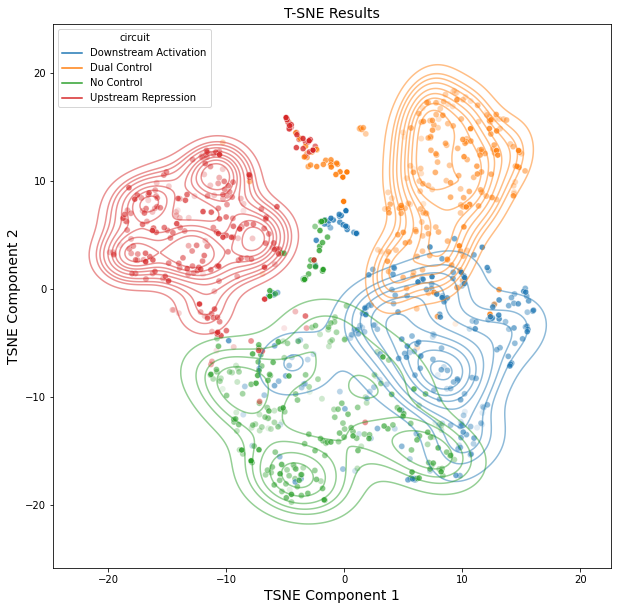

In [190]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
alphas = perturbed.normalized_perturbs.sort_values().unique()
for alpha in alphas[1:]:
    sns.scatterplot(x="tsne1", y="tsne2",
                    data=perturbed[perturbed.normalized_perturbs == alpha], hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

In [191]:
#Compute mean background losses by circuit type
background.groupby('circuit').mean().loss

circuit
Downstream Activation    0.061706
Dual Control             0.064434
No Control               0.063199
Upstream Repression      0.070033
Name: loss, dtype: float64

C:\Users\CHARLO~1\AppData\Local\Temp/ipykernel_28064/1395090879.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  d = perturbed.loc[perturbed.kc_perturb == kc].loc[perturbed.km_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss


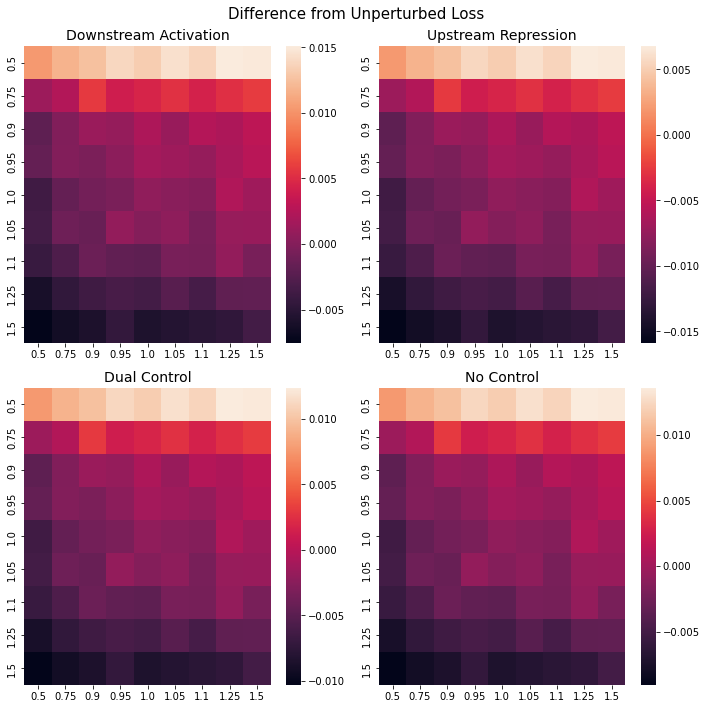

In [192]:
def get_heatmap_data(circuit, perturbed):
    circuit_df = perturbed.loc[perturbed.circuit == circuit]
    kcs = perturbed.kc_perturb.sort_values().unique()
    kms = perturbed.km_perturb.sort_values().unique()

    heatmap_data = np.zeros([len(kcs), len(kms)])
    for i in range(len(kcs)):
        for j in range(len(kms)):
            kc = kcs[i]
            km = kms[j]
            d = perturbed.loc[perturbed.kc_perturb == kc].loc[perturbed.km_perturb == km].reset_index(drop=True).loss[0] - background.loc[background.circuit == circuit].mean().loss
            heatmap_data[i][j] = d
    heatmap_data = pd.DataFrame(heatmap_data, index=kcs, columns=kms)
    return heatmap_data

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

endpoint = 'Downstream Activation'
ax = axs[0][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)

endpoint = 'Upstream Repression'
ax = axs[0][1]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)

endpoint = 'Dual Control'
ax = axs[1][0]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)

endpoint = 'No Control'
ax = axs[1][1]
ax = sns.heatmap(get_heatmap_data(endpoint, perturbed), ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)

fig.suptitle('Difference from Unperturbed Loss', fontsize=15)
fig.tight_layout()

In [300]:
landscape = pd.read_csv('test_landscape_5000.csv')

features = ['k1', 'k2', 'theta1', 'theta2', 'loss']

x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5001 samples in 0.005s...
[t-SNE] Computed neighbors for 5001 samples in 0.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5001
[t-SNE] Computed conditional probabilities for sample 2000 / 5001
[t-SNE] Computed conditional probabilities for sample 3000 / 5001
[t-SNE] Computed conditional probabilities for sample 4000 / 5001
[t-SNE] Computed conditional probabilities for sample 5000 / 5001
[t-SNE] Computed conditional probabilities for sample 5001 / 5001
[t-SNE] Mean sigma: 0.278365


C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.315315
[t-SNE] KL divergence after 300 iterations: 1.848442


In [303]:
landscape = landscape.loc[landscape.loss < 0.2]

Text(0.5, 0.98, 'Upstream Repression Landscape, Low Losses')

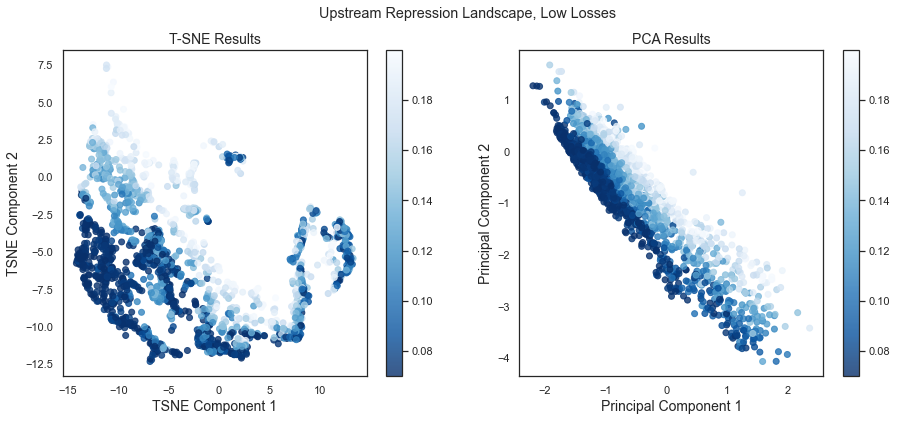

In [304]:
import matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
# sns.kdeplot(
#     data=landscape,
#     x="tsne1",
#     y="tsne2",
#     cmap='Greys',
#     thresh=.1, ax=ax, alpha=0.5
# )
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax)
#sns.scatterplot(data=landscape, x="pc1", y="pc2", hue='loss', alpha=alpha, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Upstream Repression Landscape, Low Losses')
#fig.savefig('landscape_low_losses.png')

Text(0.5, 0.98, 'Upstream Repression Landscape, 5000 Samples')

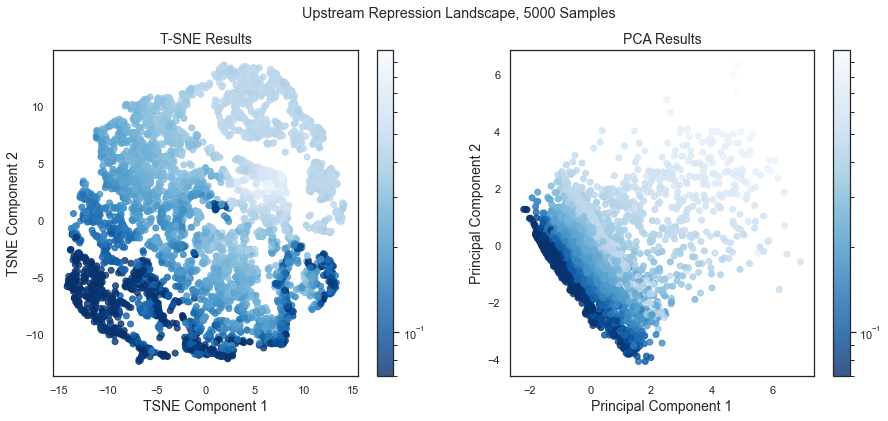

In [302]:
import matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
# sns.kdeplot(
#     data=landscape,
#     x="tsne1",
#     y="tsne2",
#     cmap='Greys',
#     thresh=.1, ax=ax, alpha=0.5
# )
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Blues_r', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Blues_r', norm=matplotlib.colors.LogNorm())
fig.colorbar(contour, ax=ax)
#sns.scatterplot(data=landscape, x="pc1", y="pc2", hue='loss', alpha=alpha, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
fig.suptitle('Upstream Repression Landscape, 5000 Samples')
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

In [211]:
#Compute mean background losses by circuit type
means = background.groupby('circuit').mean()

Text(0, 0.5, 'Principal Component 2')

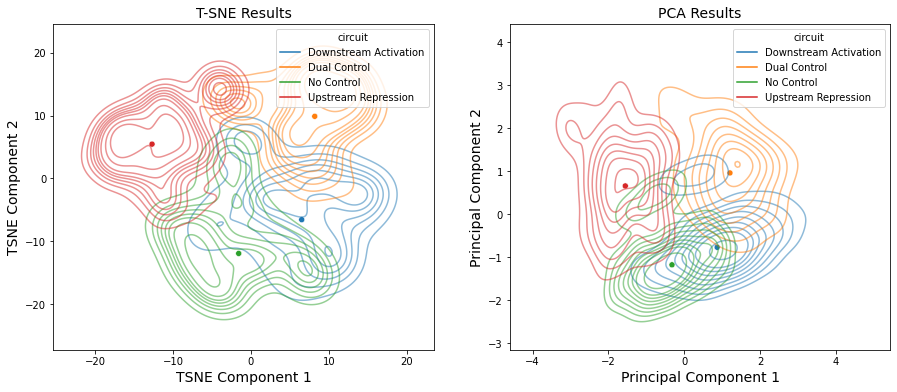

In [215]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
sns.scatterplot(x="pc1", y="pc2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

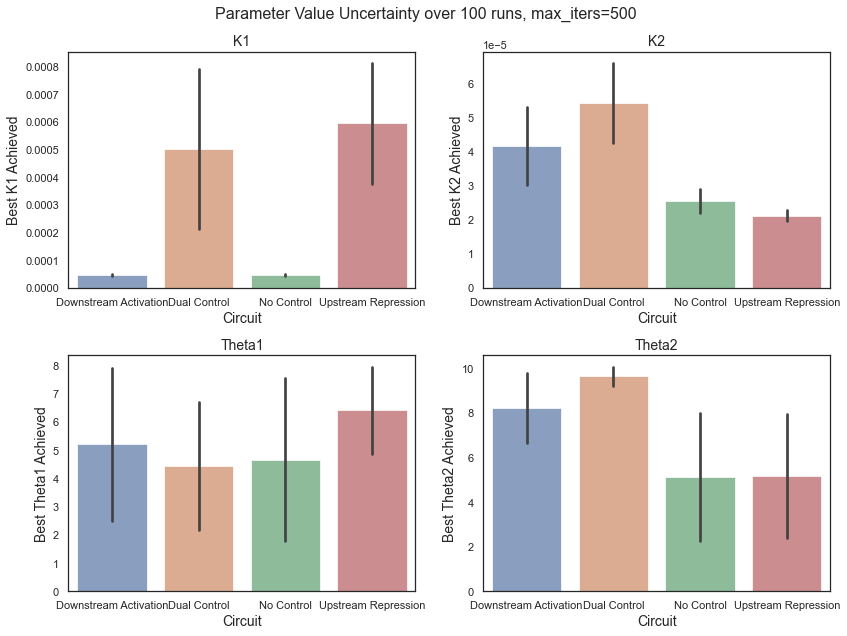

In [289]:

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
endpoint = 'K1'
ax = axs[0][0]
g = sns.barplot(
    data=background,
    x="circuit", y="k1", ci="sd", alpha=0.7, ax=ax)
ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'K2'
ax = axs[0][1]
g = sns.barplot(
    data=background,
    x="circuit", y="k2", ci="sd", alpha=0.7, ax=ax)
ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta1'
ax = axs[1][0]
g = sns.barplot(
    data=background,
    x="circuit", y="theta1", ci="sd", alpha=0.7, ax=ax)
ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta2'
ax = axs[1][1]
g = sns.barplot(
    data=background,
    x="circuit", y="theta2", ci="sd", alpha=0.7, ax=ax)
ax.set_xlabel('Circuit', fontsize=14)
ax.set_ylabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Parameter Value Uncertainty over 100 runs, max_iters=500', fontsize=16)
fig.tight_layout()
fig.savefig('param_uncertainty_500.png')

Text(0.5, 0.98, 'Theta1')

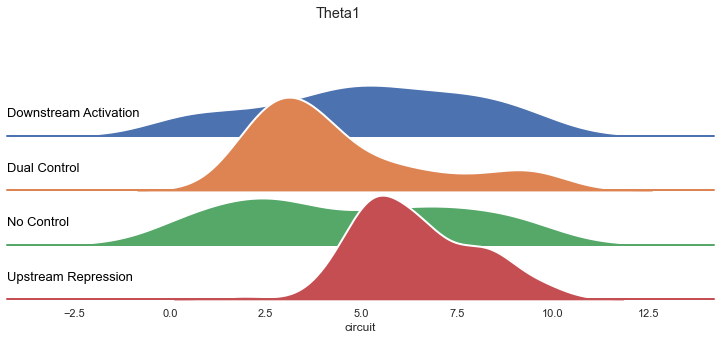

In [286]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
circuits = ['Dual Control', 'No Control', 'Downstream Activation', 'Upstream Repression']
palette = sns.color_palette()
g = sns.FacetGrid(background, palette=palette, row="circuit", hue="circuit", aspect=9, height=1.2)

g.map_dataframe(sns.kdeplot, x="theta1", fill=True, alpha=1, clip_on=False)
g.map_dataframe(sns.kdeplot, x="theta1", color='white', clip_on=False, lw=2, bw_adjust=1)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "circuit")
g.set_titles("")
g.set_ylabels("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-.5)
g.fig.suptitle('Theta1')

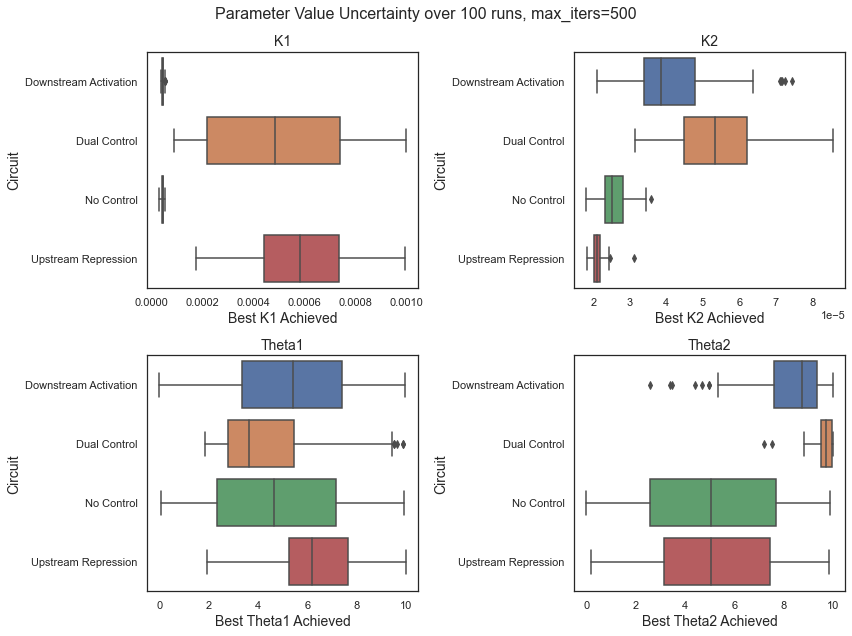

In [298]:

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
endpoint = 'K1'
ax = axs[0][0]
sns.boxplot(data=background, x='k1', y='circuit',  orient="h", ax=ax)
ax.set_ylabel('Circuit', fontsize=14)
ax.set_xlabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'K2'
ax = axs[0][1]
sns.boxplot(data=background, x='k2', y='circuit',  orient="h", ax=ax)
ax.set_ylabel('Circuit', fontsize=14)
ax.set_xlabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta1'
ax = axs[1][0]
sns.boxplot(data=background, x='theta1', y='circuit',  orient="h", ax=ax)
ax.set_ylabel('Circuit', fontsize=14)
ax.set_xlabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta2'
ax = axs[1][1]
sns.boxplot(data=background, x='theta2', y='circuit',  orient="h", ax=ax)
ax.set_ylabel('Circuit', fontsize=14)
ax.set_xlabel(f'Best {endpoint} Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Parameter Value Uncertainty over 100 runs, max_iters=500', fontsize=16)
fig.tight_layout()
fig.savefig('param_violins_500.png')


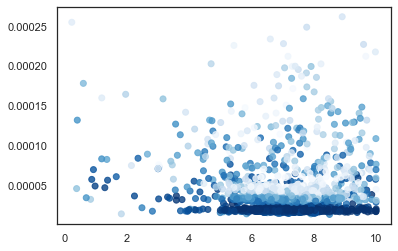

In [309]:
contour = plt.scatter(data=landscape, x="theta1", y="k2", alpha = .8, c = 'loss', cmap = 'Blues_r')

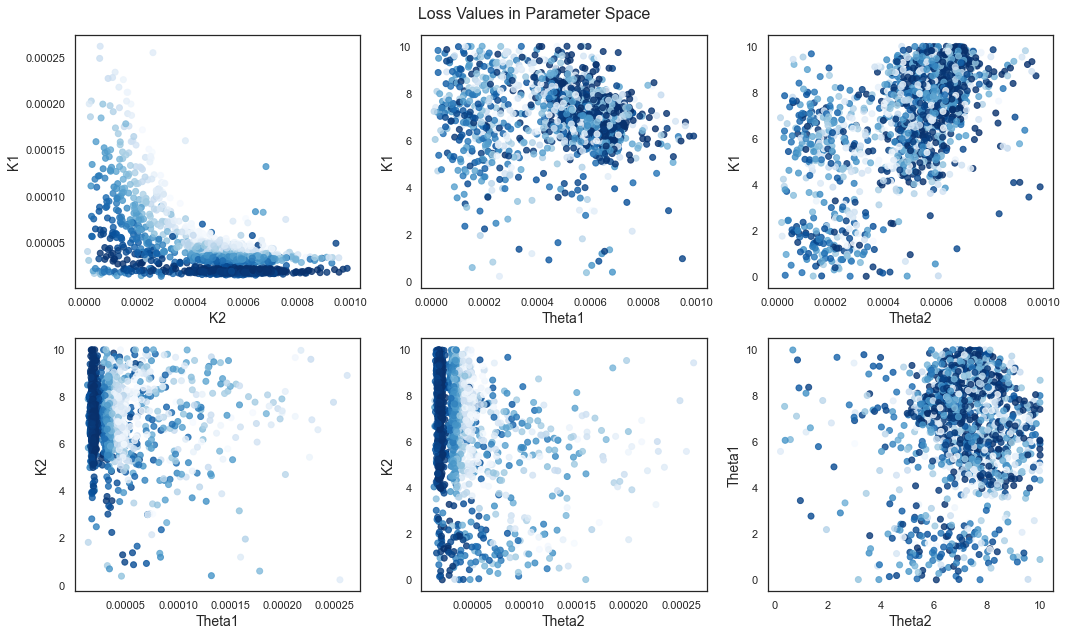

In [319]:

fig, axs = plt.subplots(2, 3, figsize=(15, 9))
ax = axs[0][0]
contour = ax.scatter(data=landscape, x="k1", y="k2", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('K1', fontsize=14)
ax.set_xlabel('K2', fontsize=14)

ax = axs[0][1]
contour = ax.scatter(data=landscape, x="k1", y="theta1", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('K1', fontsize=14)
ax.set_xlabel('Theta1', fontsize=14)

ax = axs[0][2]
contour = ax.scatter(data=landscape, x="k1", y="theta2", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('K1', fontsize=14)
ax.set_xlabel('Theta2', fontsize=14)

ax = axs[1][0]
contour = ax.scatter(data=landscape, x="k2", y="theta1", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('K2', fontsize=14)
ax.set_xlabel('Theta1', fontsize=14)

ax = axs[1][1]
contour = ax.scatter(data=landscape, x="k2", y="theta2", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('K2', fontsize=14)
ax.set_xlabel('Theta2', fontsize=14)

ax = axs[1][2]
contour = ax.scatter(data=landscape, x="theta1", y="theta2", alpha = .8, c = 'loss', cmap = 'Blues_r')
ax.set_ylabel('Theta1', fontsize=14)
ax.set_xlabel('Theta2', fontsize=14)


fig.suptitle('Loss Values in Parameter Space', fontsize=16)
fig.tight_layout()